# 7. Dimensionality reduction and clustering with UMAP: seismogram atlases

We have tested PCA and ICA for reducing the dimensions of the scattering coefficients and clustering tasks. We will now investigate Uniform Manifold Projection and Approximation (UMAP) for similar purposes. PCA and ICA preserve quite well the pair-wise distances of data points at the costs of losing information about the local structure. Because they preserve the distances, the techniques are often used for clustering tasks later on. UMAP basically learns the high-dimensional manifold of the data and maps it into a lower dimensional space. By doing so, it preserves much better the local structure but at the costs of global structures, meaning that distances between distant data points might be distorted. Therefore, more care has to be taken, if we perform clustering in the UMAP space.

In the literature, these UMAP spaces are called atlases, since they resemble a map of the data such as the activation atlas of a convolutional neural network presented in Cartler et al. 2019. Therefore, we decided to call the UMAP spaces of a continuous seismogram a "seismogram atlas". Seismogram atlases were introduced in [Steinmann et al. 2023](https://essopenarchive.org/doi/full/10.22541/essoar.168614505.54607219).

Made in April 2023 by René Steinmann and Léonard Seydoux.

Last update: 27 November 2023

> **Note**: This notebook requires the installation of the matplotlib, sklearn and umap-learn libraries, which are not included in the default installation of the scatseisnet library. To install them, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html), the [scikit-learn website](https://scikit-learn.org/stable/install.html) and the [umap-learn website](https://umap-learn.readthedocs.io/en/latest/index.html).

In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
import umap
import obspy

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

## 6.0 Load scattering coefficients

First, we load the scattering coefficients and reshape them for any [dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html) model (here `FastICA`) of the `scikit-learn` package. The shape of the scattering coefficients are given by the following tuples:

- Order 1: `(n_times, n_channel, octaves[0] * resolution[0])`
- Order 2: `(n_times, n_channel, octaves[0] * octaves[1] * resolution[0]  *
  resolution[1])`
- ...
- Order n: `(n_times, n_channel, np.prod(octaves) * np.prod(resolution))`

We then need to collect the all-order scattering coefficients into a
two-dimensional matrix for the `FastICA` application. 

> Note that the optimal way to load the scattering coefficients is to use `xarray` 

In [2]:
# Load data from file
with np.load(
    "../example/scattering_coefficients.npz", allow_pickle=True
) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log10(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 4319 samples of 504 dimensions each.


In [3]:
# Load the corresponding time vector
with np.load(
    "../example/independent_components.npz", allow_pickle=True
) as data:
    times = data["times"]

## 6.1 Apply UMAP

After loading and stacking the scattering coefficients into a matrix, we can now apply UMAP to the scattering coefficient matrix. The `n_components` keyword argument informs the model about how many components we want to extract. Since we want to visualize an "atlas", we extract 2 components. Other important hyperparameters are `n_neighbors` and `min_dist`. They kind of control the local vs global structure preservation. We will work with the default parameters. For an intuitive and detailed explanation we recommend visiting the [umap-learn website](https://umap-learn.readthedocs.io/en/latest/index.html).

/Users/seydoux/GitHub/scatseisnet/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


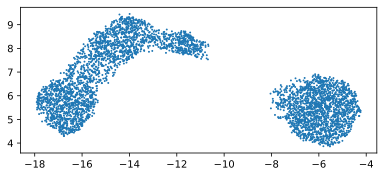

In [4]:
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding = umap_model.fit_transform(scattering_coefficients)

# Visualize the UMAP results
fig, ax = plt.subplots()
ax.scatter(embedding[:, 0], embedding[:, 1], s=1)
ax.set_aspect("equal")

### Two distinct clusters in the atlas

The seismogram atlas depicts two distinct clusters, which is very different to the two-dimensional ICA and PCA visualizations in `4_reduction`. Many cluster algorithms will be able to identify these two distinct structures and, therefore, we go with the basic k-means clustering.

## 7.2 K-Means clustering with atlas

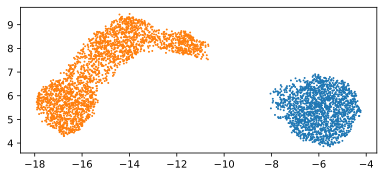

In [5]:
# clustering task
N_CLUSTERS = 2
cluster_model = KMeans(n_clusters=N_CLUSTERS)
predictions = cluster_model.fit_predict(embedding)

# show clustering results in the atlas
fig, ax = plt.subplots()
for label in np.unique(predictions):
    where = label == predictions
    ax.scatter(embedding[where, 0], embedding[where, 1], s=1)
ax.set_aspect("equal")

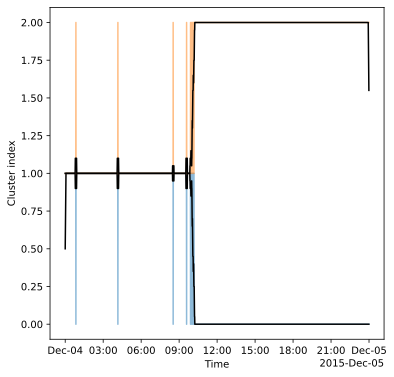

In [6]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = (
        np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same")
        / SMOOTH_KERNEL
    )

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

### Very clear temporal separation of the two clusters

Our k-means clustering in the seismogram atlas separates very sharply the tremor from the non-tremor period. The results look much cleaner than the k-means clustering in the 4-dimensional feature space of ICA (see `6_clustering`).